In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

In [3]:
import NaiveDE

In [4]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

In [5]:
import SpatialDE as sde

In [6]:
X = sample_info[['x', 'y']]

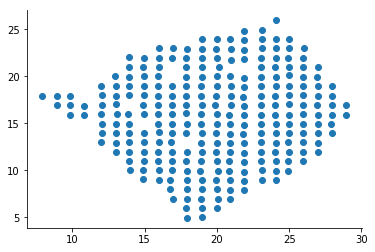

In [7]:
plt.scatter(X.x, X.y);

In [8]:
results = sde.run(X, res.sample(1000, axis=1))

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.078s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                             
INFO:root:Model 3 of 10                            
INFO:root:Model 4 of 10                            
INFO:root:Model 5 of 10                            
INFO:root:Model 6 of 10                            
INFO:root:Model 7 of 10                            
INFO:root:Model 8 of 10                            
INFO:root:Model 9 of 10                            
INFO:root:Model 10 of 10                           


In [23]:
from matplotlib.colors import LogNorm

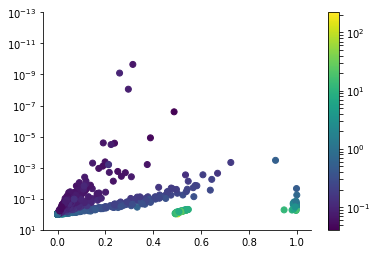

In [43]:
plt.yscale('log')
plt.scatter(results.FSV, results.pval, c=2 * np.sqrt(results.s2_FSV.values), norm=LogNorm());
plt.colorbar()
plt.ylim(1e-13, 10);
plt.gca().invert_yaxis();

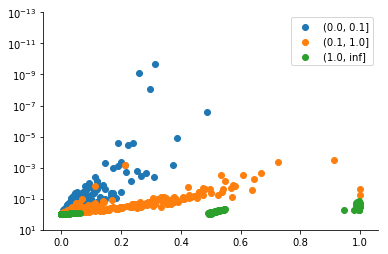

In [53]:
plt.yscale('log')
for i, g in results.groupby(pd.cut(2 * np.sqrt(results.s2_FSV), [0, 1e-1, 1e0, np.inf])):
    plt.scatter(g.FSV, g.pval, label=i);
    
plt.legend()
plt.ylim(1e-13, 10);
plt.gca().invert_yaxis();

In [ ]:
def remake_matrices(result, X, exp_mat):
    K = sde.base.SE_kernel(X, result.l.values[0])
    U, S = sde.base.factor(K)
    UT1 = sde.base.get_UT1(U)
    UTy = sde.base.get_UTy(U, exp_mat[result.g.values[0]])
    n = X.shape[0]
    
    return UTy, UT1, S, n

In [ ]:
logdeltas = np.linspace(-10, 20)

In [ ]:
bad_gene = results.query('fraction_spatial_variance > 0.8 > pval > 1e-5').sample()

In [ ]:
plt.yscale('log')
plt.scatter(results.fraction_spatial_variance, results.pval);
plt.scatter(bad_gene.fraction_spatial_variance, bad_gene.pval);
plt.ylim(1e-13, 1);
plt.gca().invert_yaxis();

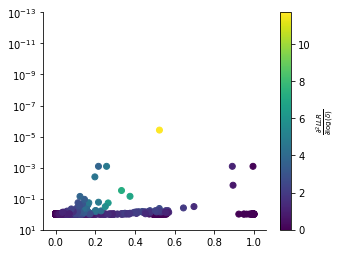

In [47]:
plt.yscale('log')
plt.scatter(results.fraction_spatial_variance, results.qval, c=results.d2delta);
plt.ylim(1e-13, 10);
plt.colorbar(label=r'$\frac{\partial^2 LLR}{\partial \log(\delta)}$');
plt.gca().invert_yaxis();

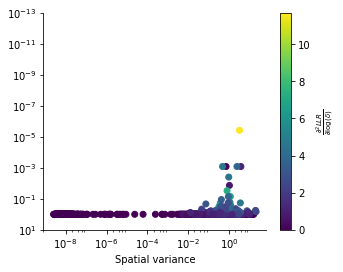

In [48]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(results.max_s2_t_hat * results.Gower, results.qval, c=results.d2delta);
plt.xlabel('Spatial variance')
plt.ylim(1e-13, 10);
plt.colorbar(label=r'$\frac{\partial^2 LLR}{\partial \log(\delta)}$');
plt.gca().invert_yaxis();

In [58]:
UTy, UT1, S, n = remake_matrices(bad_gene, X, res)
LL_obj = sde.base.make_objective(*(UTy, UT1, S, n))
lls = np.array([LL_obj(d) for d in logdeltas])

In [59]:
from scipy.misc import derivative

In [60]:
x0 = np.log(bad_gene.max_delta.values[0])
s2_delta = 1. / derivative(LL_obj, x0, n=2)

In [61]:
s2_t_hat = lambda d: sde.base.s2_t_hat(np.exp(d), UTy, S, n)

In [62]:
s2_s2_t_hat = np.abs(derivative(s2_t_hat, x0, n=1)) ** 2 * s2_delta

In [63]:
s2_s2_t_hat

0.019351477082913824

In [69]:
def FSV(logdelta):
    s2_t = sde.base.s2_t_hat(np.exp(logdelta), UTy, S, n)
    g = bad_gene.Gower.values[0]
    
    return s2_t * g / (s2_t * g + np.exp(logdelta) * s2_t)

In [75]:
derivative(FSV, x0, n=1) ** 2 * s2_delta

0.0086390210180979036

In [64]:
bad_gene

,Gower,M,d2delta,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,time,BIC,max_ll_null,LLR,fraction_spatial_variance,pval,qval
181,0.999516,4,0.000624,PHLDB1,0.378583,0.001986,-2.866423,-1.340987,1.663622,SE,250,0.001025,27.81869,-3.411474,0.545051,0.998017,0.460347,0.974739


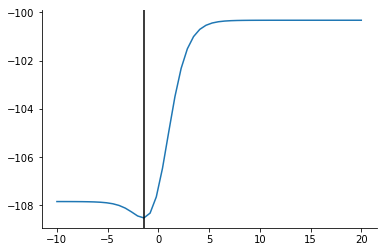

In [20]:
plt.plot(logdeltas, lls);
plt.axvline(np.log(bad_gene.max_delta.values[0]), c='k');

In [21]:
lls

array([-107.83714101, -107.83747329, -107.83808584, -107.83921451,
       -107.84129224, -107.84511058, -107.85210582, -107.86484758,
       -107.88781184, -107.92840118, -107.9976203 , -108.108133  ,
       -108.2640198 , -108.43436771, -108.51459431, -108.31576403,
       -107.64306895, -106.4541778 , -104.95546764, -103.49136965,
       -102.31987473, -101.51028999, -101.00338035, -100.70493452,
       -100.53549195, -100.44126071, -100.38945711, -100.36115829,
       -100.34575301, -100.33738253, -100.33283908, -100.33037431,
       -100.32903759, -100.32831278, -100.32791979, -100.32770672,
       -100.32759121, -100.32752859, -100.32749464, -100.32747623,
       -100.32746625, -100.32746084, -100.32745791, -100.32745632,
       -100.32745546, -100.32745499, -100.32745474, -100.3274546 ,
       -100.32745453, -100.32745449])

In [22]:
from scipy import stats

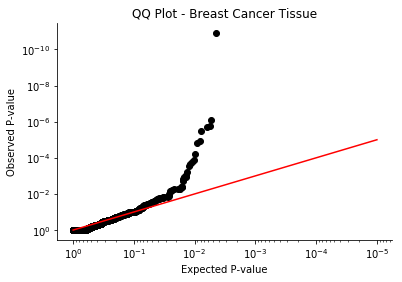

In [23]:
deg_f = 1
chi2_samples = pd.Series(stats.chi2.rvs(df=1, size=results.LLR.shape[0]))
pval_samples = 1 - stats.chi2.cdf(chi2_samples.sort_values(), df=deg_f)
pval_observed = 1 - stats.chi2.cdf(results.LLR.sort_values(), df=deg_f)

plt.loglog()
plt.scatter(pval_samples, pval_observed, marker='o', c='k', rasterized=True);
plt.plot([1e-5, 1], [1e-5, 1], c='r');

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Expected P-value')
plt.ylabel('Observed P-value');

plt.title('QQ Plot - Breast Cancer Tissue');

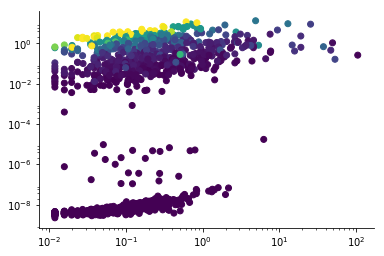

In [24]:
plt.loglog()
plt.scatter(df[results.g].var(), results.max_s2_t_hat * results.Gower, c=results.fraction_spatial_variance);

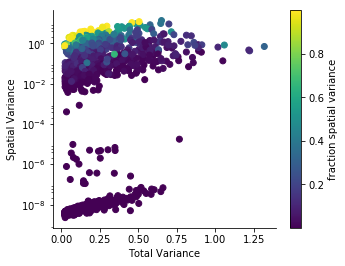

In [25]:
figsize(5, 4)
plt.yscale('log')
plt.scatter(res[results.g].var(), results.max_s2_t_hat * results.Gower, c=results.fraction_spatial_variance);
plt.xlabel('Total Variance');
plt.ylabel('Spatial Variance')
plt.colorbar(label='fraction spatial variance');

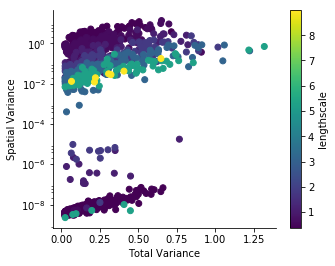

In [26]:
figsize(5, 4)
plt.yscale('log')
plt.scatter(res[results.g].var(), results.max_s2_t_hat * results.Gower, c=results.l);
plt.xlabel('Total Variance');
plt.ylabel('Spatial Variance')
plt.colorbar(label='lengthscale')

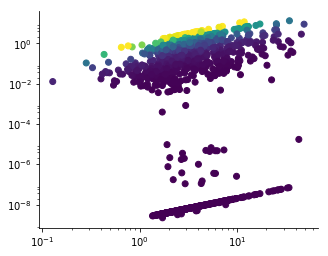

In [27]:
plt.yscale('log')
plt.xscale('log')
noise_var = results['max_s2_t_hat'] * results['max_delta']
plt.scatter(noise_var + results.max_s2_t_hat * results.Gower,
            results.max_s2_t_hat * results.Gower,
            c=results.fraction_spatial_variance);